# Drift and Diffusion in XENON1T


La forma degli eventi S2 è determinata da 3 parametri: **drift velocity**, **diffusion constant** e **SPE waveform model**. Qui ci concentriamo sui primi 2 parametri.

## Drift Velocity

Viene calcolato dalla differenza dei centri di S1 e the S2 ed è contenuto in `event_basics`. 


In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy import stats
import straxen
from multihist import Histdd, Hist1d

import sys
import os.path as osp
from straxen import units
import pandas as pd

In [2]:
st = straxen.contexts.xenon1t_dali()

In [3]:
runs = st.select_runs(available='event_info')

Checking data availability: 100%|██████████| 5/5 [00:52<00:00, 10.49s/it]


In [4]:
st.data_info('event_basics')

,Field name,Data type,Comment
0,time,int64,Start time since unix epoch [ns]
1,endtime,int64,Exclusive end time since unix epoch [ns]
2,n_peaks,int32,Number of peaks in the event
3,drift_time,int32,Drift time between main S1 and S2 in ns
4,s1_index,int32,Main S1 peak index in event
5,alt_s1_index,int32,Alternate S1 peak index in event
6,s1_time,int64,Main S1 start time since unix epoch [ns]
7,alt_s1_time,int64,Alternate S1 start time since unix epoch [ns]
8,s1_center_time,int64,Main S1 weighted center time since unix epoch ...
9,alt_s1_center_time,int64,Alternate S1 weighted center time since unix e...


In [5]:
st.data_info('corrected_areas')

,Field name,Data type,Comment
0,cs1,float32,Corrected S1 area [PE]
1,cs2,float32,Corrected S2 area [PE]
2,alt_cs1,float32,Corrected area of the alternate S1 [PE]
3,alt_cs2,float32,Corrected area of the alternate S2 [PE]
4,time,int64,Start time since unix epoch [ns]
5,endtime,int64,Exclusive end time since unix epoch [ns]


In [6]:
print('Number of runs:', len(runs))

Number of runs: 205


Il codice seguente fa un loop su più run e riempie i vettori con i drift times (in `event_basics`) ed il rapporto tra le aree dopo la correzione (in `corrected_areas`)

In [38]:
def select_events(runs,nr):
    s2 = []
    cs1 = []
    cs2 = []
    s2_50 = []
    s2_aft = []
    drift_times = []
    data = pd.DataFrame(columns=['cs1','cs2','s2','s2_a50','s2_aft','drift_times'])
    print(data)
    for i in range(nr):
        run_info = runs.iloc[i]
        events = st.get_array(run_info['name'],'event_basics')
        c_areas = st.get_array(run_info['name'],'corrected_areas')
        for k in range(len(events)):
            s2.append(events['s2_area'][k]) 
            s2_50.append(events['s2_range_50p_area'][k])
            s2_aft.append(events['s2_area_fraction_top'][k])
            drift_times.append(events['drift_time'][k] / units.us)
            cs1.append(c_areas['cs1'][k])
            cs2.append(c_areas['cs2'][k])
    data['cs1'] = cs1
    data['cs2'] = cs2
    data['s2'] = s2
    data['s2_50'] = s2_50
    data['s2_aft'] = s2_aft
    data['drift_times'] = drift_times
    print('First run:',runs.iloc[0]['name'],'Last run:',runs.iloc[nr]['name'])
    print('Total number of events:',len(s2))
    data.to_hdf('data.h5', key='data', mode='w')
    #return s2, cs1, cs2, s2_50, s2_aft, drift_times
    return data

In [41]:
#s2, cs1, cs2, s2_50, s2_aft, drift_times = select_events(runs,20)
select_events( runs, 20 )

Empty DataFrame
Columns: [cs1, cs2, s2, s2_a50, s2_aft, drift_times]
Index: []
First run: 170204_1410 Last run: 170205_1013
Total number of events: 387780


/dali/lgrandi/strax/miniconda3/envs/strax/lib/python3.7/site-packages/pandas/core/generic.py:2505: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->floating,key->block1_values] [items->Index(['s2_a50'], dtype='object')]

  encoding=encoding,


,cs1,cs2,s2,s2_a50,s2_aft,drift_times,s2_50
0,404.569733,1.287258e+01,1.402659e+01,NaN,0.273708,0.466,234.551239
1,554.553345,1.858536e+05,1.882497e+05,NaN,0.535207,1.017,218.465912
2,783.354797,1.905735e+05,1.794275e+05,NaN,0.569273,2.582,414.187195
3,8682.543945,1.006112e+06,1.002154e+06,NaN,0.395081,5.862,497.115112
4,617.486084,2.327477e+02,2.006601e+02,NaN,0.669255,6.212,2828.729980
...,...,...,...,...,...,...,...
387775,1331.202759,7.032261e+04,5.804334e+04,NaN,0.666954,9.032,429.041870
387776,2652.592529,1.643762e+05,1.447799e+05,NaN,0.600809,67.316,708.989258
387777,0.000000,2.215704e+05,2.036376e+05,NaN,0.546377,0.000,352.209045
387778,9310.903320,1.857406e+02,1.913911e+02,NaN,0.189716,1.974,1196.771606


In [2]:
data = pd.read_hdf('data.h5', 'data')

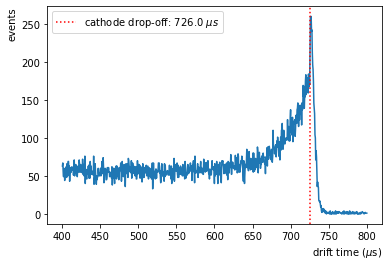

In [3]:
drift_hist, drift_bin = np.histogram(data['drift_times'],bins=800, range=(400,800))
plt.plot(drift_bin[1:],drift_hist)
plt.xlabel('drift time ($\mu$s)', ha='right', x=1)
plt.ylabel('events', ha='right', y=1)
drift_max = drift_bin[int(drift_hist.argmax())]
plt.axvline(drift_max, c='red', linestyle=":",label=f'cathode drop-off: {drift_max:.1f} $\mu s$')
plt.legend()
plt.savefig("drift-time.png")

Il massimo nello spettro del **drift time**: il rate di eventi aumenta scendendo nella TPC, dato che la schermo di xenon (da gamma provenienti da materiali sotto la TPC) si riduce sempre di più; fino a diminuire improvvisamente dato che S2 non possoono essere collezionati da sotto il catodo.

### Ratio Between S2 and S1 corrected areas

Text(0, 1, 'events')

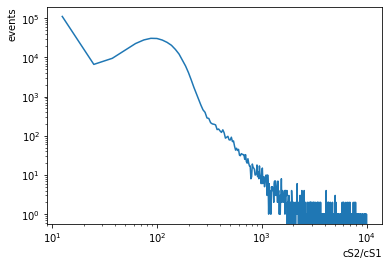

In [4]:
import math
area_ratio = np.zeros(len(data))
area_ratio10 = np.zeros(len(data))
bool = (data['cs1']>0) & (data['cs2']>0) & (np.invert(np.isnan(data['cs1'])))
for i in range(len(data)):
    if bool[i]:
        area_ratio[i] = data['cs2'][i]/data['cs1'][i]
        area_ratio10[i] = math.log10(data['cs2'][i]/data['cs1'][i])
#if bool: area_ratio[:] = cs2[:]/cs1[:]
area_hist, area_bin = np.histogram(area_ratio,bins=800, range=(0,10000))
plt.plot(area_bin[1:],area_hist)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('cS2/cS1', ha='right', x=1)
plt.ylabel('events', ha='right', y=1)

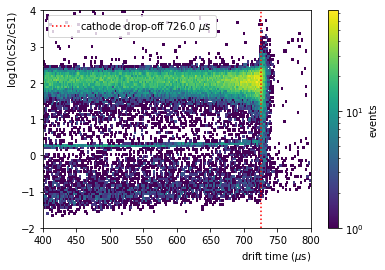

In [5]:
#plt.scatter(drift_times,area_ratio10, marker='.', s=20)
#plt.xlim(400,800)
#plt.ylim(-2,4)
d_vs_a = Histdd(data['drift_times'], area_ratio10,
            bins=(np.linspace(400, 800, 200), np.linspace(-2, 4, 100)))
#plt.figure(figsize=(20,10))
d_vs_a.plot(log_scale=True, cblabel='events')
plt.xlabel('drift time ($\mu$s)', ha='right', x=1)
plt.ylabel('log10(cS2/cS1)', ha='right', y=1)
plt.axvline(drift_max, c='red', linestyle=":",label=f'cathode drop-off {drift_max:.1f} $\mu s$')
plt.legend()
plt.savefig("dt-area_high.png")

* **low S2/S1 events**, sono prodotti da electron clouds che si trovano nella regione di inversione del campo al catodo, parte della carica va verso **bottom screen** e non risale all'anodo
* **large S2s** sono prodotti in regione con alto campo vicino i fili del catodo; questo sopprime l'effetto di ricombinazione delle coppie, aumentando quindi S2

**Campi Elettrici nella TPC**
1. campo elettrico tra il catodo (negativo, in basso) e il gate, serve per muovere gli elettroni verso il gas
2. campo elettrico tra il gate e l'anodo (positivo, in alto), serve per estrarre gli elettroni che eccitano e/o ionizzano gli atomi del gas e producono S2 

### Drift time of gate events

Gli eventi creati al gate non sono visibili nello spettro del drift time, bisogna guardare a tempi più bassi se guardiamo però la regione a bassi. Eventi possono essere generati anche nel sottile strato tra il gate e l'anodo.

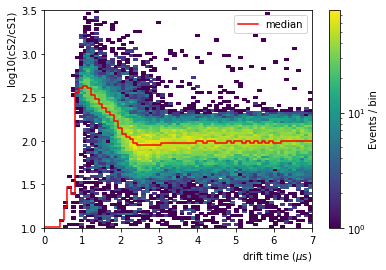

In [6]:
mh = Histdd(data['drift_times'], area_ratio10,
            bins=(np.linspace(0, 7, 70), np.linspace(1, 3.5, 100)),
            axis_names=['drift_time', 'area_ratio'])
mh.plot(log_scale=True, cblabel='Events / bin')
plt.xlabel("drift time ($\mu$s)", ha='right', x=1)
plt.ylabel("log10(cS2/cS1)", ha='right', y=1)

median = mh.percentile(50, axis='area_ratio')
#n_per_slice = mh.sum(axis='logcsratio')
#sigma = (mh.percentile(stats.norm.cdf(1)*100, axis='logcsratio') - 
#         mh.percentile(stats.norm.cdf(-1)*100, axis='logcsratio'))/2
#plt.errorbar(median.bin_centers, median.histogram,
#             yerr=sigma/np.sqrt(n_per_slice.histogram), c='red')
median.plot(color='red',label='median')
plt.legend()
plt.savefig("dt-area_low.png")

A tempi sotto i 3 $\mu$s il rapporto cS1/cS2 sale, questo è dovuto al fatto che il campo elettrico cresce passando il gate sopprimento l'effetto di ricombinazione e quindi aumentando S2 a discapito di S1.

La posizione orientativo del gate è dove c'è il rapido cambio intorno a $1.5~\mu$s.

### Drift Velocity

In [7]:
cathode_dt = drift_max * units.us
dt_offset = 1.5 * units.us
tpc_length = 97 * units.cm #lunghezza approssimata della TPC di XENON1T
drift_velocity = tpc_length / (cathode_dt - dt_offset)
print("Drift velocity determined at %0.3f km/sec" % (drift_velocity/(units.km/units.s)))

Drift velocity determined at 1.339 km/sec


## Diffusion Constant

### Richiamo di teoria

The diffusion constant $D$ describes the diffusive broadening of electron clouds, and eventually the S2 signals, with increasing drift time.

Non ci sono molti lavori a riguardo, si prende come riferimento quello di [Sorensen](https://arxiv.org/abs/1102.2865) che definisce la devisione standard del segnale S2 (per un infinitely thin gas gap):

\begin{equation}
\sigma = \frac{\sqrt{2 D t}}{v}
\end{equation}
il numeratore è la larghezza longitudinale dell'electron cloud con $t$ the drift time, $v$ è la drift velocity. 

Per $t$ lunghi ($>30\mu$s per Sorensen), la diffusione rende la forma di S2 ancora una gaussiana approssimata, si usa una versione modificata dell'equazionee:

\begin{equation}
\sigma = \sqrt{\frac{2 D t}{v^2} + {\sigma_0}^2}
\end{equation}
dove $\sigma_0$ è una costante da settare; se la risposta al SPE fosse una gaussiana perfetta, $\sigma_0$ sarebbe la larghezza di very shallow S2s.

Viene utilizzata l'area al 50% area $r_{50}$ per misurare la larghezza di S2, in modo da evitare la coda. Facendo l'aprossimazione di gaussiana $r_{50} \approx 1.349 \sigma$ si può scrivere:

\begin{equation}
r_{50} = \sqrt{\frac{3.6395 D t}{v^2} + {w_0}^2}
\end{equation}

### S2 width vs energy
la larghezza dipende dall'energia per 2 effetti:

* i segnali S2 hanno una certa distribuzione per la width dovuta al numero finito di elettroni, a **bassa statistica** gli stimatori della larghezza non sono molto corretti;
* al contrario, per gli S2 ad **alte energie** c'è la saturation dell'ADC, che taglia parte dell'area e questo provoca un aumento della larghezza (con S2 ~ 30k PE) (vedere meglio questa cosa)


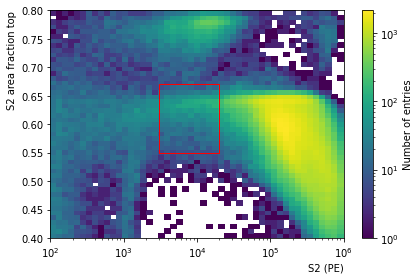

In [8]:
s2_top2 = Histdd(data['s2'], data['s2_aft'],bins=(np.logspace(2, 6, 50), np.linspace(0.4, 0.8, 50)))
s2_top2.plot(log_scale=True)
s2_bounds = (3e3, 2e4)
aft_bounds = (0.55, 0.67)
plt.gca().add_patch(matplotlib.patches.Rectangle(
        (s2_bounds[0], aft_bounds[0]), s2_bounds[1] - s2_bounds[0], 
    aft_bounds[1] - aft_bounds[0],
    edgecolor='red',facecolor='none'))

plt.xscale('log')
plt.xlabel('S2 (PE)', ha='right', x=1)
plt.ylabel('S2 area fraction top', ha='right', y=1)
plt.tight_layout()


Per gli effetti descritti sopra si guarda **S2** che è sensibile alla saturazione (e non cS2) vs **S2 area fraction top (AFT)**.

Jelle utilizza i tagli mostrati nel grafico: s2[10k:20k] e AFT[0.55:0.7].

AFT diminuisce ad alte energia: questo anche è dovuto alla saturazione nel top array.

Text(0, 0.5, 'S2 width range 50% area (ns)')

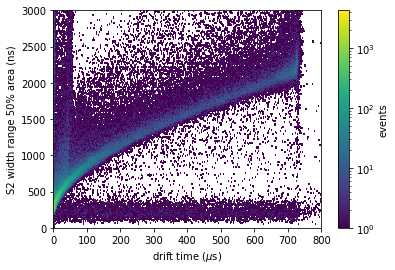

In [9]:
width_hist = Histdd(data['drift_times'], data['s2_50'],
            bins=(np.linspace(0, 800, 800), np.linspace(0, 3e3, 200)));
width_hist.plot(log_scale=True, cblabel='events')
plt.xlabel('drift time ($\mu$s)')
plt.ylabel('S2 width range 50% area (ns)')

Text(0, 0.5, 'S2 width range 50% area (ns)')

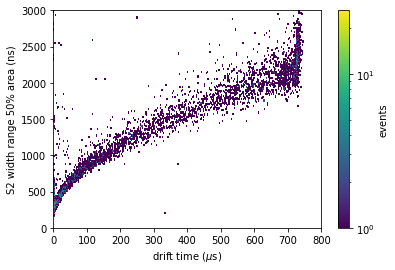

In [10]:
data_cut = data[(data['s2']>s2_bounds[0]) & (data['s2']<s2_bounds[1]) &
            (data['s2_aft']>aft_bounds[0]) & (data['s2_aft']<aft_bounds[1])]
width_hist_cut = Histdd(data_cut['drift_times'], data_cut['s2_50'],
            bins=(np.linspace(0, 800, 800), np.linspace(0, 3e3, 200)));
width_hist_cut.plot(log_scale=True, cblabel='events')
plt.xlabel('drift time ($\mu$s)')
plt.ylabel('S2 width range 50% area (ns)')

Il taglio su S2 rimuove:
* eventi di alta energia dove si ha la saturazione dell'ADC (e questo allarga artificialmente S2-width)
* eventi di bassa energia dove non vale l'equazione della diffusione per la statistica bassa

Il taglio sulla frazione vista dai PMT in alto (S2_AFT) rimuove:
* eventi che avvengono nelle vicinanze del top array (o nel gas) che hanno un `drift time` breve e una larghezza maggiore

### Fit to determine the Diffusion Constant
Per fare il fit vengono usati soltanto tempi tra 50 e 350 us:
* in basso per garantire che S2 abbia una distribuzione guassiana
* in alto per rimuovere eventi ad alta statistica che producono eventi anomali

In [31]:
from scipy.optimize import curve_fit
from tqdm import tqdm
import emcee

D_guess = 30 * units.cm**2 / units.s
w0_guess = 300 * units.ns
wsigma_guess = 30 * units.ns
sigma_to_r50p = stats.norm.ppf(0.75) - stats.norm.ppf(0.25)
def diffusion_model(t, D, vd, w0):
    return np.sqrt(2 * sigma_to_r50p**2 * D * t / vd**2 + w0**2)

def fit_diffusion(drift_times, s2_50, vd, outlier_cap=-15):
    def loglikelihood(params):
        D, w0, wsigma = params

        # Range constraint / uniform prior. Probably not necessary anymore.
        if not (5 < D < 50 and (100  < w0/units.ns < 500) and (10 < wsigma/units.ns < 100)):
            return -float('inf')

        D *= (units.cm**2 / units.s)

        y = s2_50
        model = diffusion_model(drift_times, D, vd, w0)

        # Gaussian loglikelihood, with outlier contribution capped
        inv_sigma2 = 1.0/wsigma**2
        result = -0.5 * ((y-model)**2*inv_sigma2 - np.log(inv_sigma2))
        result = np.clip(result, outlier_cap, 1)
        return np.sum(result)

    guess = np.array([D_guess/(units.cm**2 / units.s), w0_guess, wsigma_guess])
    n_walkers = 50
    n_steps = 250
    n_dim = len(guess)

    # Hack to show a progress bar during the computation
    def lnprob(x):
        lnprob.t.update(1)
        return loglikelihood(x)
    lnprob.t = tqdm(desc='Computing likelihoods', total=n_walkers * n_steps)

    # Run the MCMC sampler
    p0 = np.array([np.random.uniform(0.9, 1.1, size=n_dim) for i in range(n_walkers)]) * guess
    sampler = emcee.EnsembleSampler(n_walkers, n_dim, lnprob)
    samples = sampler.run_mcmc(p0, n_steps)

    # Remove first 50 samples for each walker (burn-in)
    samples = sampler.chain.ravel()
    samples = sampler.chain[:, 50:, :].reshape((-1, n_dim))
    return samples

In [46]:
D_fit_range_us = (10, 300)
data_fit = data_cut[(data_cut['drift_times']>D_fit_range_us[0]) &
                   (data_cut['drift_times']<D_fit_range_us[1])]
samples = fit_diffusion(data_fit['drift_times'], data_fit['s2_50'], vd=drift_velocity)









Computing likelihoods:   0%|          | 0/12500 [00:00<?, ?it/s]







Computing likelihoods:   0%|          | 27/12500 [00:00<00:46, 269.89it/s]







Computing likelihoods:   0%|          | 58/12500 [00:00<00:44, 279.37it/s]







Computing likelihoods:   1%|          | 92/12500 [00:00<00:42, 294.75it/s]







Computing likelihoods:   1%|          | 124/12500 [00:00<00:41, 300.07it/s]







Computing likelihoods:   1%|▏         | 158/12500 [00:00<00:39, 310.39it/s]







Computing likelihoods:   2%|▏         | 192/12500 [00:00<00:38, 317.72it/s]







Computing likelihoods:   2%|▏         | 225/12500 [00:00<00:38, 319.35it/s]







Computing likelihoods:   2%|▏         | 259/12500 [00:00<00:37, 324.07it/s]







Computing likelihoods:   2%|▏         | 290/12500 [00:00<00:38, 318.51it/s]







Computing likelihoods:   3%|▎         | 322/12500 [00:01<00:38, 318.38it/s]







Computing likelihoods:   3%|▎         | 354/12500 [00:01<00:38, 312.79it/s]







Computing 

Computing likelihoods:  25%|██▍       | 3097/12500 [00:08<00:22, 410.48it/s]







Computing likelihoods:  25%|██▌       | 3140/12500 [00:08<00:25, 362.72it/s]







Computing likelihoods:  25%|██▌       | 3185/12500 [00:08<00:24, 384.35it/s]







Computing likelihoods:  26%|██▌       | 3234/12500 [00:08<00:22, 410.67it/s]







Computing likelihoods:  26%|██▋       | 3283/12500 [00:08<00:21, 429.84it/s]







Computing likelihoods:  27%|██▋       | 3332/12500 [00:08<00:20, 443.20it/s]







Computing likelihoods:  27%|██▋       | 3386/12500 [00:08<00:19, 466.38it/s]







Computing likelihoods:  28%|██▊       | 3442/12500 [00:08<00:18, 487.70it/s]







Computing likelihoods:  28%|██▊       | 3492/12500 [00:08<00:19, 473.78it/s]







Computing likelihoods:  28%|██▊       | 3541/12500 [00:08<00:19, 467.42it/s]







Computing likelihoods:  29%|██▊       | 3589/12500 [00:09<00:19, 459.33it/s]







Computing likelihoods:  29%|██▉       | 3637/12500 [00:09<00:19, 464.55it/s]

Computing likelihoods:  54%|█████▍    | 6758/12500 [00:15<00:12, 444.29it/s]







Computing likelihoods:  54%|█████▍    | 6808/12500 [00:16<00:12, 459.49it/s]







Computing likelihoods:  55%|█████▍    | 6857/12500 [00:16<00:12, 468.00it/s]







Computing likelihoods:  55%|█████▌    | 6904/12500 [00:16<00:12, 460.26it/s]







Computing likelihoods:  56%|█████▌    | 6951/12500 [00:16<00:13, 419.71it/s]







Computing likelihoods:  56%|█████▌    | 7000/12500 [00:16<00:12, 436.54it/s]







Computing likelihoods:  56%|█████▋    | 7047/12500 [00:16<00:12, 443.51it/s]







Computing likelihoods:  57%|█████▋    | 7101/12500 [00:16<00:11, 465.85it/s]







Computing likelihoods:  57%|█████▋    | 7149/12500 [00:16<00:11, 456.72it/s]







Computing likelihoods:  58%|█████▊    | 7196/12500 [00:16<00:11, 452.22it/s]







Computing likelihoods:  58%|█████▊    | 7242/12500 [00:17<00:12, 431.84it/s]







Computing likelihoods:  58%|█████▊    | 7286/12500 [00:17<00:12, 422.31it/s]

Computing likelihoods:  83%|████████▎ | 10404/12500 [00:23<00:04, 487.73it/s]







Computing likelihoods:  84%|████████▎ | 10455/12500 [00:24<00:04, 491.28it/s]







Computing likelihoods:  84%|████████▍ | 10509/12500 [00:24<00:03, 502.90it/s]







Computing likelihoods:  84%|████████▍ | 10562/12500 [00:24<00:03, 508.84it/s]







Computing likelihoods:  85%|████████▍ | 10613/12500 [00:24<00:03, 487.61it/s]







Computing likelihoods:  85%|████████▌ | 10663/12500 [00:24<00:03, 481.04it/s]







Computing likelihoods:  86%|████████▌ | 10712/12500 [00:24<00:03, 481.17it/s]







Computing likelihoods:  86%|████████▌ | 10761/12500 [00:24<00:03, 470.05it/s]







Computing likelihoods:  86%|████████▋ | 10809/12500 [00:24<00:03, 443.70it/s]







Computing likelihoods:  87%|████████▋ | 10857/12500 [00:24<00:03, 453.93it/s]







Computing likelihoods:  87%|████████▋ | 10903/12500 [00:25<00:03, 453.71it/s]







Computing likelihoods:  88%|████████▊ | 10956/12500 [00:25<00:03,

Diffusion constant = 32.87 cm^2/s


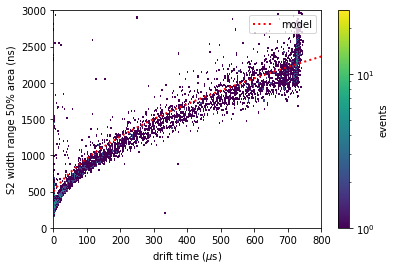

In [47]:
fit_result = np.median(samples, axis=0)
l, r = np.percentile(samples, 100 * stats.norm.cdf([-1, 1]), axis=0)
sigma = (r - l)/2
q = np.round(fit_result, 2), np.round(sigma, 2)
D = fit_result[0] * (units.cm**2 / units.s)
w0 = fit_result[1]
print(f'Diffusion constant = {D/(units.cm**2 / units.s):.2f} cm^2/s')
width_hist_cut.plot(log_scale=True, cblabel='events')
plt.xlabel('drift time ($\mu$s)')
plt.ylabel('S2 width range 50% area (ns)')
ts = np.linspace(0, 800, 100) * units.us
plt.plot(ts / units.us, diffusion_model(ts, D, drift_velocity, w0),
         linestyle=':', linewidth=2, c='r',label='model')
plt.legend()
plt.savefig('diffusion_constant.png')

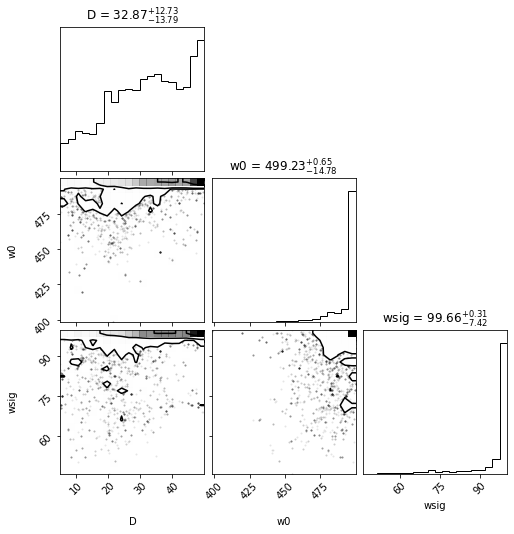

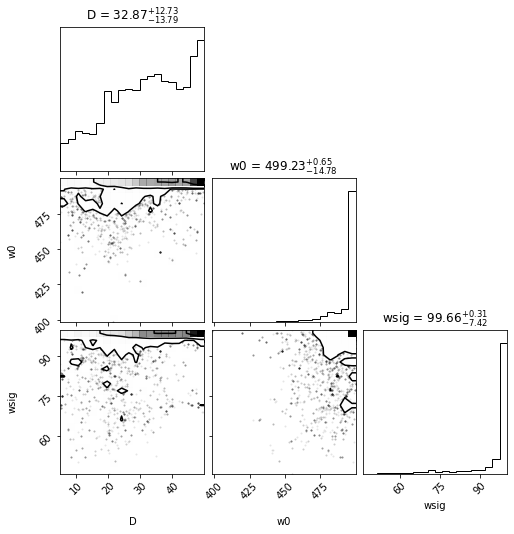

In [48]:
import corner
corner.corner(samples, show_titles=True, labels=['D', 'w0', 'wsig'])
#plt.savefig('D_corner_%s' % ds['desc'])